In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'D:\Stock_trend_project\data\interim\train_clean_after_2010_and_bad_tickers.csv')



FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Stock_trend_project\\data\\interim\\train_clean_after_2010_and_bad_tickers.csv'

توزيع الأسعار عبر جميع الأسهم

توزيع أسعار الأسهم عبر جميع الأسطر وجميع الأسهم في الداتاسيت.
الهدف هو فهم:
- نطاق الأسعار (Minimum, Maximum).
- أماكن تركز القيم (Where most prices lie).
- وجود أي قيم شاذة أو ذيول طويلة في التوزيع (Outliers, Long Tails).

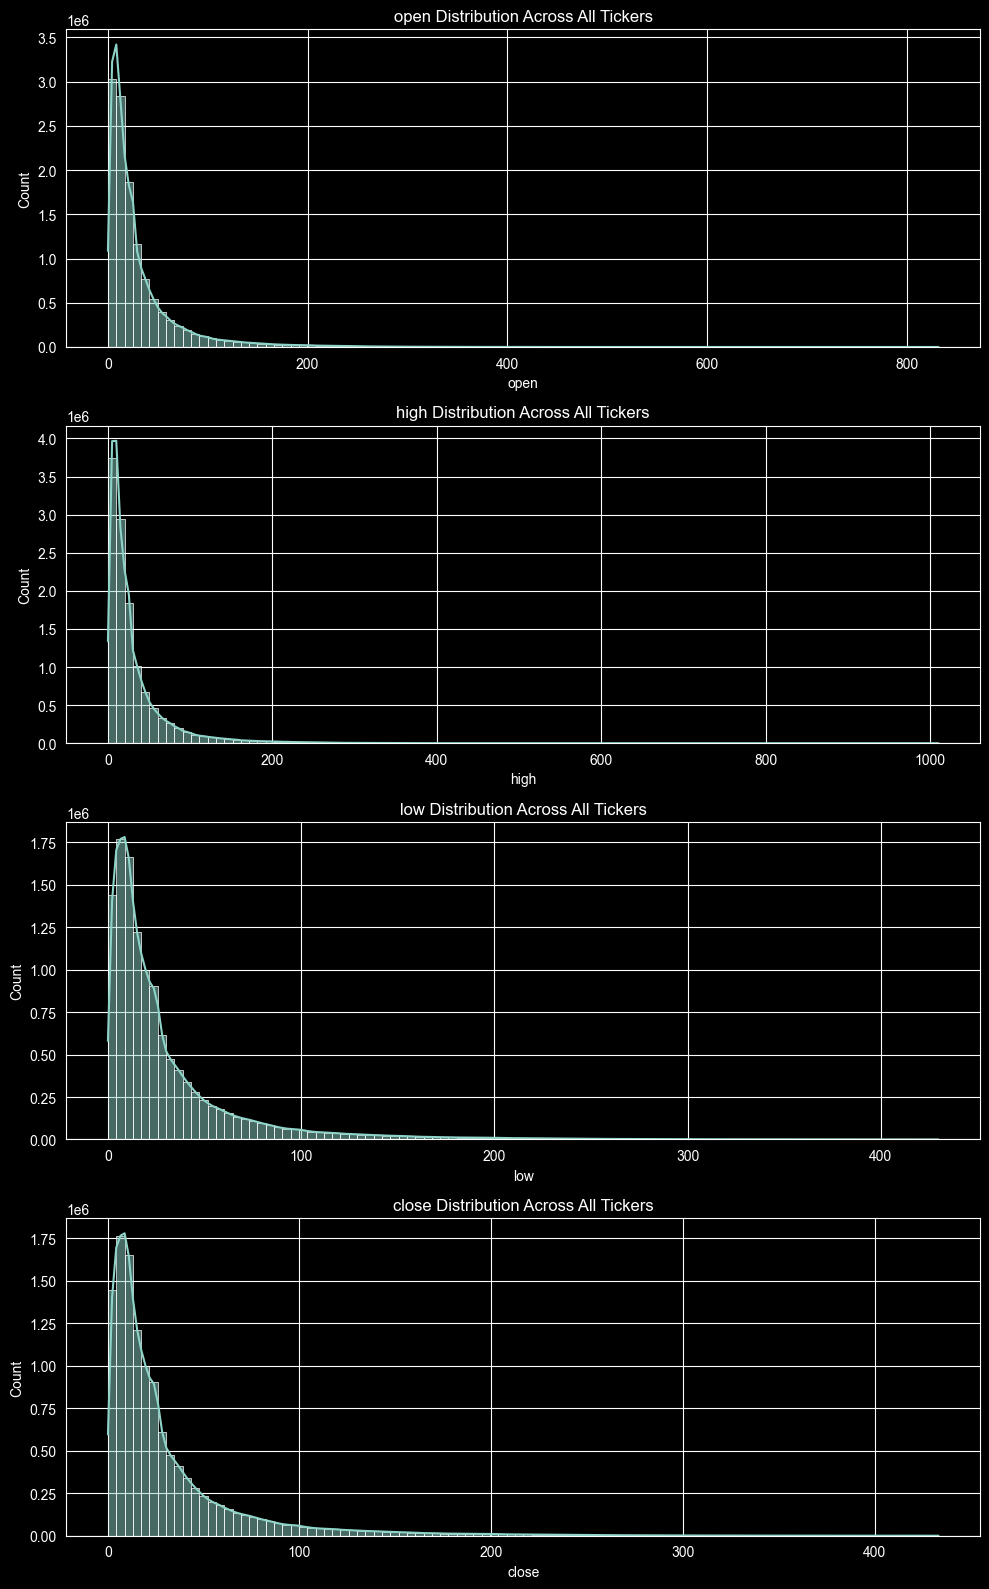

In [4]:


price_cols = ["open", "high", "low", "close"]

fig, axes = plt.subplots(len(price_cols), 1, figsize=(10, 4*len(price_cols)))

for i, col in enumerate(price_cols):
    ax = axes[i]
    sns.histplot(
        data=df,
        x=col,
        bins=100,
        kde=True,
        ax=ax
    )
    ax.set_title(f"{col} Distribution Across All Tickers")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


Continuous Variables Analysis

Price distributions across all companies

This code reshapes the Open, High, Low, and Close columns into a long format and then plots a stacked histogram of the raw price values, colored by price type, to show how each type of price is distributed across all records and companies in the dataset.

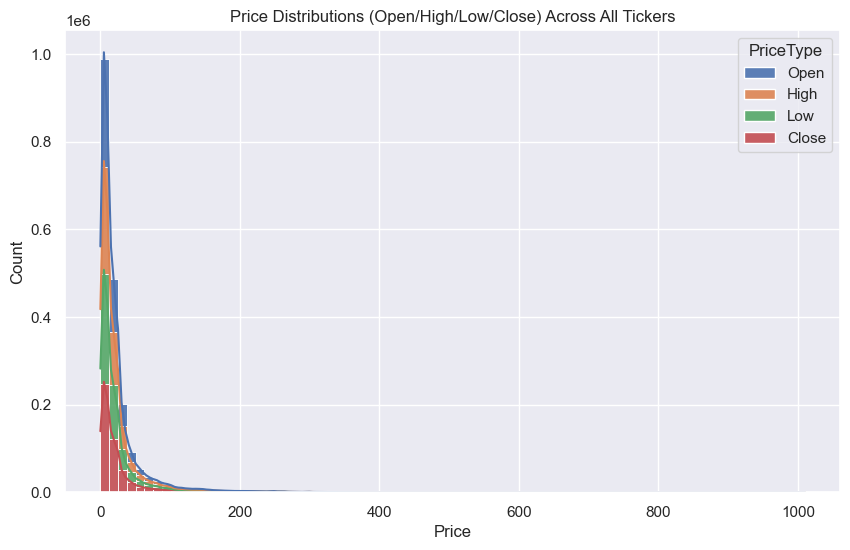

In [14]:

prices_long = df.melt(
    value_vars=price_cols,
    var_name="PriceType",
    value_name="Price"
)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=prices_long,
    x="Price",
    hue="PriceType",
    bins=80,
    kde=True,
    multiple="stack",
    alpha=0.9,
)

plt.title("Price Distributions (Open/High/Low/Close) Across All Tickers")
plt.xlabel("Price")
plt.ylabel("Count")

plt.show()



## Extreme stock prices and outliers

In this section, I:
- Compute the global minimum and maximum prices across Open/High/Low/Close.
- Identify which tickers and dates correspond to these extreme price values.
- Visualize price outliers using a boxplot to see if there are unusually high or low prices that may need special handling in the model.


Global min price: 0.0
Global max price: 1010.0800170898438

Rows with global MAX price:


,ticker,date,open,high,low,close
10090635,ticker_4784,2022-09-01,831.919983,1010.080017,328.0,419.200012



Rows with global MIN price:


,ticker,date,open,high,low,close
9784488,ticker_4468,2021-09-29,130.0,140.399994,0.0,140.399994


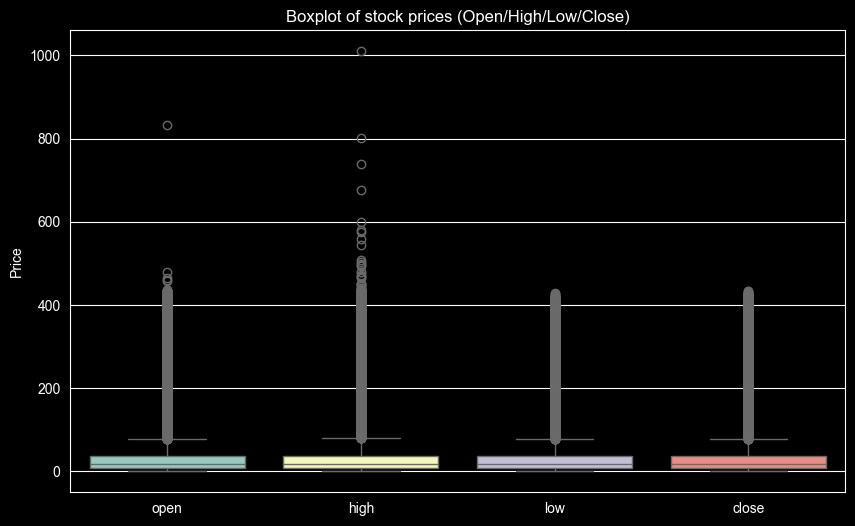

In [5]:

price_cols = ["open", "high", "low", "close"]

global_min = df[price_cols].min().min()
global_max = df[price_cols].max().max()

print("Global min price:", global_min)
print("Global max price:", global_max)

high_price_mask = df[price_cols].max(axis=1) == global_max
low_price_mask  = df[price_cols].min(axis=1) == global_min

high_price_rows = df.loc[high_price_mask, ["ticker", "date"] + price_cols]
low_price_rows  = df.loc[low_price_mask,  ["ticker", "date"] + price_cols]

print("\nRows with global MAX price:")
display(high_price_rows.head())

print("\nRows with global MIN price:")
display(low_price_rows.head())

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[price_cols])
plt.title("Boxplot of stock prices (Open/High/Low/Close)")
plt.ylabel("Price")
plt.show()

## Volume distribution and outliers

In this section:
- I analyze the distribution of trading volume using a **log-transformed** histogram `log(1 + Volume)` to handle the strong right skew.
- I use a **boxplot** on the raw `Volume` values to visually highlight extreme trading days.
- I compute IQR-based bounds to **count and inspect Volume outliers**, which may require special treatment before training the model.


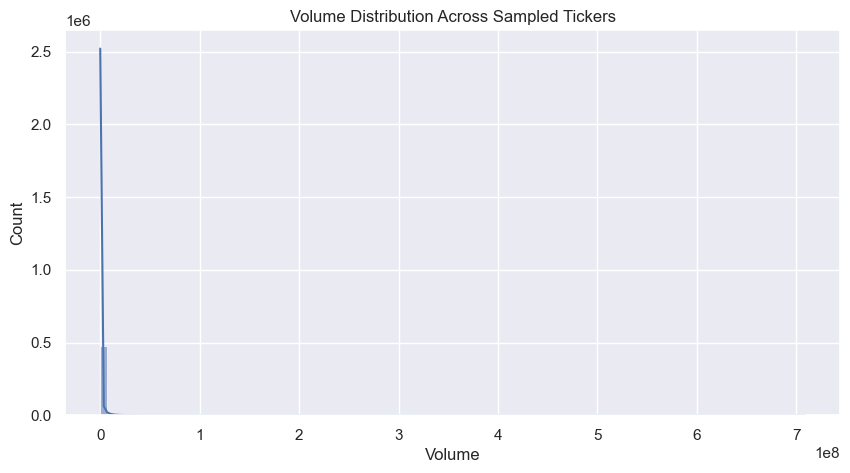

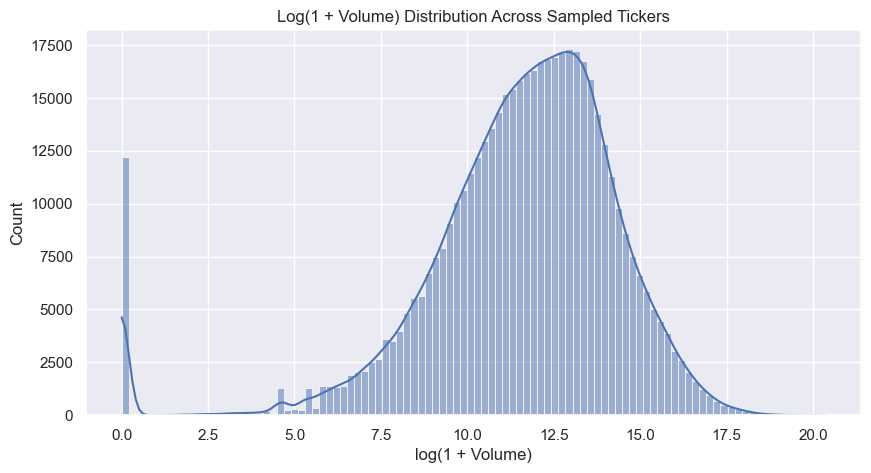

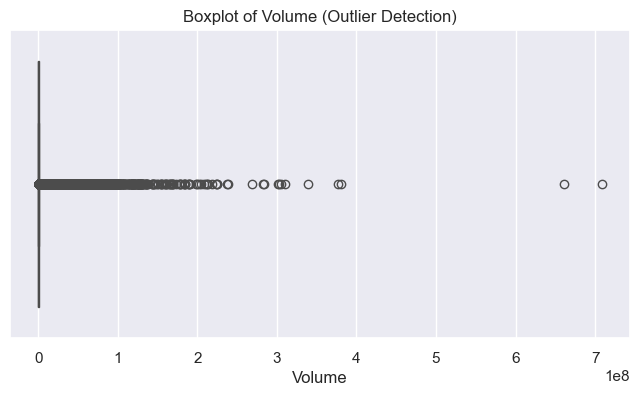

IQR-based Volume outliers count: 64228


,Ticker,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
7859806,ticker_1002,2008-11-03,31.383587,32.076336,30.669848,31.614504,2680000.0,0.0,0.0
7891634,ticker_1002,2008-11-24,31.078812,31.276364,30.133395,30.803654,2474700.0,0.0,0.0
7925634,ticker_1002,2008-12-16,28.736439,29.209148,28.362506,29.068041,1843100.0,0.0,0.0
8762403,ticker_1002,2010-06-17,43.707731,45.488718,43.612058,45.297371,2760300.0,0.0,0.0
13617802,ticker_1002,2017-08-24,98.279825,98.803982,93.413882,93.920570,5352400.0,0.0,0.0


In [14]:

plt.figure(figsize=(10, 5))
sns.histplot(
    x=np.log1p(df["volume"]),
    bins=100,
    kde=True
)
plt.title("Log(1 + Volume) Distribution Across Sampled Tickers")
plt.xlabel("log(1 + Volume)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(
    x=df["volume"]
)
plt.title("Boxplot of Volume (Outlier Detection)")
plt.xlabel("Volume")
plt.show()

q1 = df["volume"].quantile(0.25)
q3 = df["volume"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_volume = df[
    (df["volume"] < lower_bound) |
    (df["volume"] > upper_bound)
]

print("IQR-based Volume outliers count:", len(outliers_volume))
display(outliers_volume.head())


### Daily price range vs. volume

Here I explored whether days with larger intraday price movement (`DailyRange = High - Low`) tend to have higher trading activity (`log(1 + Volume)`). The scatter plot shows a dense cloud near small ranges and a wide spread in volume, and the correlation (~0.13) is weakly positive. This suggests only a mild relationship between daily price range and volume, so this feature may add limited but not dominant signal to the model.


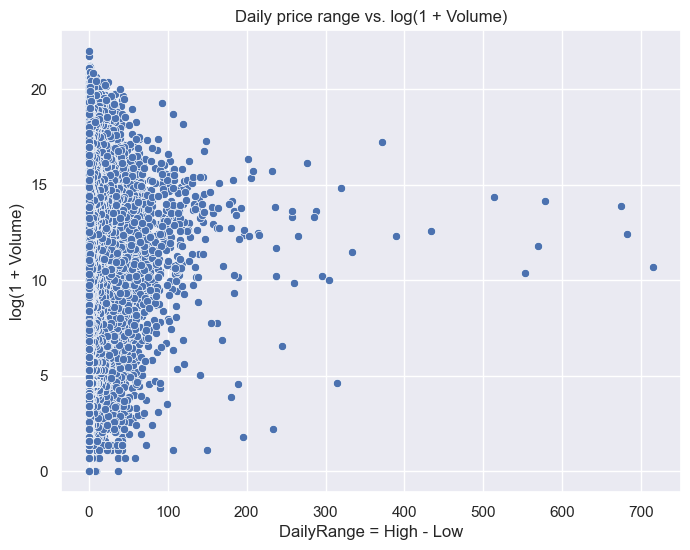

Correlation between DailyRange and log(1 + Volume): 0.13309440621794294


In [5]:

df["DailyRange"] =  df["High"] - df["Low"]

df[["DailyRange", "volume"]].describe()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="DailyRange",
    y=np.log1p(df["Volume"])
)
plt.title("Daily price range vs. log(1 + Volume)")
plt.xlabel("DailyRange = High - Low")
plt.ylabel("log(1 + Volume)")
plt.show()

corr = df["DailyRange"].corr(np.log1p(df["Volume"]))
print("Correlation between DailyRange and log(1 + Volume):", corr)


Close price range per company

This code groups the data by company ticker, computes the minimum and maximum Close for each company, then derives a Close_range = max(Close) - min(Close) and plots a histogram of these ranges to show how widely closing prices move across different companies.

Summary of Close price ranges across tickers:


count    5000.000000
mean       69.373200
std        82.113117
min         0.000000
25%        15.293633
50%        36.195498
75%        89.441866
max       434.258344
Name: Close_range, dtype: float64

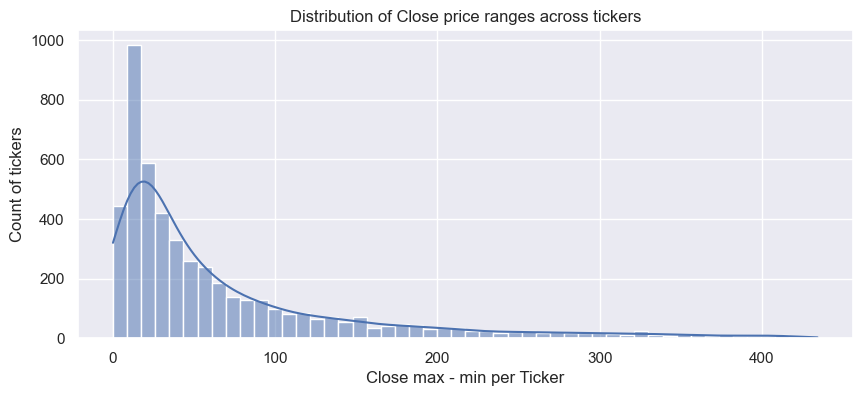

In [7]:
price_cols = ["Open", "High", "Low", "Close"]

price_ranges = (
    df
    .groupby("Ticker")[price_cols]
    .agg(["min", "max"])
)

price_ranges["Close_range"] = (
    price_ranges["Close"]["max"] - price_ranges["Close"]["min"]
)

print("Summary of Close price ranges across tickers:")
display(price_ranges["Close_range"].describe())

plt.figure(figsize=(10, 4))
sns.histplot(price_ranges["Close_range"], bins=50, kde=True)
plt.title("Distribution of Close price ranges across tickers")
plt.xlabel("Close max - min per Ticker")
plt.ylabel("Count of tickers")
plt.show()


In [ ]:
import pandas as pd
import numpy as np

def count_price_outliers_iqr(df: pd.DataFrame,
                             price_cols=("open", "high", "low", "close"),
                             iqr_factor: float = 1.5) -> pd.DataFrame:
    """
    يحسب عدد القيم المتطرفة في الأسعار الخام لكل سهم ولكل عمود سعر
    باستخدام IQR لكل ticker على حدة.
    """
    df = df.copy()
    price_cols = list(price_cols)

    # نحفظ نتائج العلامات (True/False) لكل عمود
    outlier_flags = {col: [] for col in price_cols}

    def mark_outliers(group: pd.DataFrame) -> pd.DataFrame:
        g = group.copy()
        for col in price_cols:
            q1 = g[col].quantile(0.25)
            q3 = g[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_factor * iqr
            upper = q3 + iqr_factor * iqr
            flag = (g[col] < lower) | (g[col] > upper)
            outlier_flags[col].append(flag)
        return g

    # نمر على كل ticker ونبني flags
    df.groupby("ticker", group_keys=False).apply(mark_outliers)

    # دمج الـ flags في DataFrame واحد بنفس الفهرس
    for col in price_cols:
        df[f"{col}_is_outlier"] = pd.concat(outlier_flags[col]).reindex(df.index)

    # تلخيص: عدد القيم المتطرفة لكل ticker ولكل عمود سعر
    summary = (
        df.groupby("ticker")[[f"{c}_is_outlier" for c in price_cols]]
        .sum()
        .rename(columns=lambda c: c.replace("_is_outlier", "_outliers_count"))
    )

    # إجمالي المتطرفات لكل ticker
    summary["total_outliers"] = summary.sum(axis=1)

    return df, summary

df_with_flags, outlier_summary = count_price_outliers_iqr(df)

print(outlier_summary.head())
print("إجمالي القيم المتطرفة في الأسعار:", outlier_summary["total_outliers"].sum())


In [ ]:
import pandas as pd
import numpy as np

def count_return_outliers_iqr(
    df: pd.DataFrame,
    price_col: str = "close",
    iqr_factor: float = 1.5
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    يحسب العوائد لكل سهم، ثم يحدد القيم المتطرفة في العوائد باستخدام IQR لكل ticker.
    يرجع:
      - df_returns: الداتا مع أعمدة return و return_is_outlier
      - summary: تلخيص بعدد ونسبة القيم المتطرفة لكل ticker
    """
    df = df.copy()
    df = df.sort_values(["ticker", "date"])

    # حساب العائد البسيط لكل سهم
    df["return"] = (
        df.groupby("ticker")[price_col]
        .pct_change()
    )

    # نحذف أول صف لكل سهم (العائد NaN) من حساب outliers فقط
    def mark_outliers(group: pd.DataFrame) -> pd.DataFrame:
        g = group.copy()
        # نستثني القيم NaN (أول يوم مثلاً)
        valid = g["return"].dropna()
        if valid.empty:
            g["return_is_outlier"] = False
            return g

        q1 = valid.quantile(0.25)
        q3 = valid.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_factor * iqr
        upper = q3 + iqr_factor * iqr

        g["return_is_outlier"] = (g["return"] < lower) | (g["return"] > upper)
        # لا نعتبر NaN كقيمة متطرفة
        g.loc[g["return"].isna(), "return_is_outlier"] = False

        return g

    df_returns = (
        df
        .groupby("ticker", group_keys=False)
        .apply(mark_outliers)
    )

    # تلخيص بعدد ونسبة القيم المتطرفة لكل سهم
    summary = (
        df_returns
        .groupby("ticker")
        .agg(
            n_rows=("return", "count"),
            n_outliers=("return_is_outlier", "sum"),
        )
    )
    summary["outliers_ratio"] = summary["n_outliers"] / summary["n_rows"] * 100

    return df_returns, summary

df_ret, summary = count_return_outliers_iqr(df)

print(summary.head())
print("إجمالي القيم المتطرفة في العوائد:", int(summary["n_outliers"].sum()))
print("نسبة القيم المتطرفة في العوائد (%):",
      100 * summary["n_outliers"].sum() / summary["n_rows"].sum())

